<a href="https://colab.research.google.com/github/nahuelalmeira/redesNeuronales/blob/master/practico1/Practico1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El sistema de dos ecuaciones diferenciales ordinarias definido como:

\begin{cases}
\dot{C} &= \alpha C - \beta C Z \\
\dot{Z} &= -\gamma Z + \delta C Z
\end{cases}

es conocido como **Modelo de predadores y presas de Lokta-Volterra**. La función $C(t)$ modela el número de conejos en un ecosistema dado, y $Z(t)$ la cantidad de zorros en el mismo ecosistema.

a) Construí el diagrama de flujo con las herramientas teóricas presentadas en el curso para el caso particular en que los parámetros toman los siguientes valores:

$$
\alpha = 0.1\quad
\beta = 0.02\quad
\gamma = 0.3\quad
\delta = 0.01
$$

b) Reflexioná sobre los significados biológicos de cada uno de los términos y coeficientes $\alpha$, $\beta$, $\gamma$ y $\delta$ de las ecuaciones. Construí y analizá biológicamente el diagrama de fase.

c) Encontrá una solución numérica aproximada al problema para el caso particular en que los parámetros toman los siguientes valores del punto a) entre $t= 0$ y $t = 200$, para un paso de integración $h = 0.05$ y para las condiciones iniciales

$$
C(0) = 40\quad \mathrm{y} \quad Z(0) = 9.
$$

Recordá que esto se denomina **problema de valor inicial**.

d) Graficá, con los resultados del punto anterior, $C(t)$ vs. $Z(t)$ en un mismo gráfico (gráfico paramétrico), entre $t=0$ y $t=200$ y comentá los resultados.

### **Equilibrios**

Los equilibrios, o puntos fijos, del sistema, se definen como los puntos $(C^*,Z^*)$ tales que $\dot{C} = \dot{Z} = 0$.

Por inspección, podemos ver fácilmente que $P_1 := (0,0)^T$ es un punto fijo. Para determinar si existen más equilibrios, supongamos $C^* \neq 0$. Luego, de la primera ecuación del sistema se deduce que $Z^* = \beta / \alpha$. Dado que los parámetros del sistema son todos positivos, deducimos entonces de la segunda ecuación que $C^* = \gamma / \delta$. Es decir, $P_2:= (\beta/\alpha, \gamma/\delta)^T$ es punto fijo.

### **Estabilidad**

Linealizamos el sistema. Para ello, calculamos la matriz jacobiana

$$
A =
\begin{bmatrix}
\alpha - \beta Z & -\beta C \\
\delta Z & -\gamma + \delta C
\end{bmatrix}
$$

#### Equilibrio $P_1 = (0,0)^T$

$$
A =
\begin{bmatrix}
\alpha & 0 \\
0 & -\gamma
\end{bmatrix}
$$

La matriz jacobiana es diagonal, y sus autovalores son $\lambda_1 = \alpha > 0$ y $\lambda_2 = -\gamma < 0$. Es decir, se trata de un punto saddle. Los autovectores correspondientes son $v_1 = (1, 0)$, correspondiente a la dirección estable, y $v_2 = (0, 1)$, correspondiente a la dirección inestable. 

#### Equilibrio $P_2:= (\beta/\alpha, \gamma/\delta)^T$

$$
A =
\begin{bmatrix}
0 & -\dfrac{\beta \gamma}{\delta} \\
\dfrac{\alpha \delta}{\beta} & 0
\end{bmatrix}
$$

Diagonalizando obtenemos el polinomio característico

$$
\lambda^2 + \alpha \gamma = 0.
$$

Luego, los autovalores son imaginarios puros de la forma $\lambda_{\pm} = i \omega_{\pm}$, con $\omega_{\pm} = \pm \sqrt{\alpha \gamma}$. El hecho de que los autovalores tengan una componente imaginaria indica que las trayectorias cercanas al punto fijo oscilan en torno al mismo. Sin embargo, como la parte real es nula, el criterio no permite determinar la estabilidad del mismo.


#### Nullclinas

Partiendo de las ecuaciones, podemos ver que las nullclinas están descriptas por las curvas

$$
\begin{align}
\dot{C} &= 0\quad  \Rightarrow \quad C = 0 \quad \mathrm{\wedge}\quad Z = \beta / \alpha \\
\dot{Z} &= 0\quad  \Rightarrow \quad Z = 0 \quad \mathrm{\wedge}\quad C = \gamma / \delta 
\end{align}
$$

Además, observando los signos de las derivadas no nulas sobre las nullclinas, podemos determinar que el flujo oscila en torno al equilibrio $E_2$ en dirección antihoraria.

#### Adimensionalización

Para continuar analizando el sistema, conviene adimensionalizar las ecuaciones. Para ello, definimos constantes $a$, $b$, $c$, $d$ y $\tau$, y nuevas variables $x$ e $y$ tales que

$$
x(t) = \dfrac{\delta C(t)}{\gamma}, \quad y(t) = \dfrac{\beta Z(t)}{\alpha}, \quad \tau = \alpha t, \quad r = \gamma / \alpha.
$$

Con estas definiciones, podemos reescribir nuestro sistema como 

$$
\begin{cases}
\dot{x} &= x (1-y) \\
\dot{y} &= ry (x-1).
\end{cases}
$$

En el plano de fases adimensionalizado $xy$, las trayectorias están descriptas por las soluciones a la ecuación diferencial

$$
\dfrac{dy}{dx} = r\dfrac{y(x-1)}{x(1-y)}.
$$

Integrando esta ecuación, obtenemos

$$
rx + y - \ln x^r y = E,
$$

con $E = \mathrm{cte}$.
Es decir, el sistema es conservativo y $E$ es la "energía", o cantidad conservada, del sistema. Además, podemos ver que el punto $P_2$, que en las nuevas coordenadas es $P_2 = (1,1)$, es un mínimo de la energía. Sabiendo esto, podemos aplicar un teorema (Teorema 6.5.1, Strogatz), que dice que cualquier trayectoria cercana a $P_2$ es una curva cerrada. En otras palabras, $P_2$ es un centro.

In [1]:
## Importamos paquetes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import solve_ivp
from numpy.fft import fft, fftfreq

%matplotlib inline


## Parámetros para graficar
sns.set_style('darkgrid')
sns.set_context('talk')

BLUE = '#1f77b4'
ORANGE = '#ff7f0e'
GREEN = '#2ca02c'
a = 1

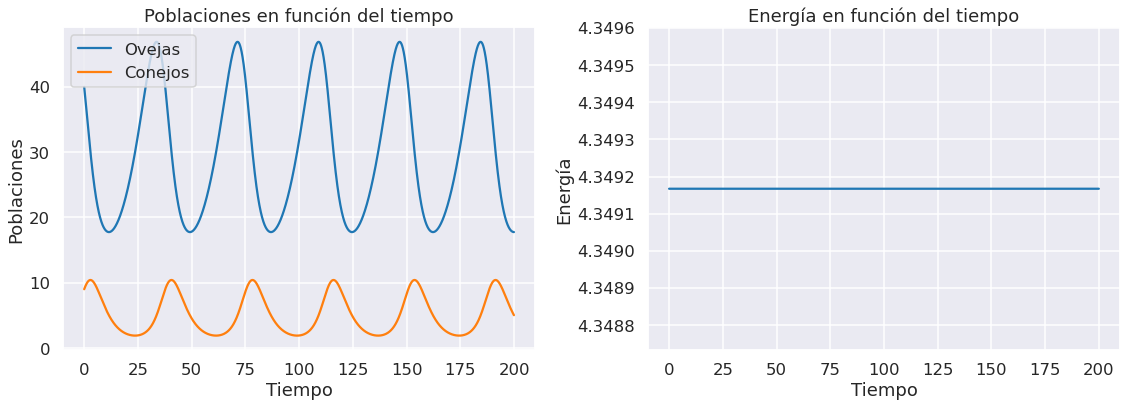

In [44]:
def FoxesVsRabbits(t, y, *args):
    """
    Sistema de tipo Lokta-Volterra, con interacción de dos
    especies competidoras: conejos (r) y ovejas (s).
    """
    c, z = y
    alpha, beta, gamma, delta = args

    dcdt = alpha*c - beta*c*z
    dzdt = -gamma*z + delta*c*z

    dydt = (dcdt, dzdt)

    return dydt

def energia(y, *args):
    """
    Calcula la energia del sistema
    """
    c, z = y
    alpha, beta, gamma, delta = args
    
    r = gamma / alpha
    x = delta * c / gamma
    y = beta * z / alpha
    
    E = r*x + y - np.log(x**r * y)
    
    return E

alpha = 0.1
beta  = 0.02
gamma = 0.3
delta = 0.01
args = (alpha, beta, gamma, delta)

## Parámetros de integración
t0 = 0
tf = 200
h = 0.05
t_span = (t0, tf)
t_eval = np.arange(t0, tf, h)

## Definimos condicion inicial e integramos
y0 = (40, 9)
sol = solve_ivp(
    FoxesVsRabbits, t_span=t_span, y0=y0, 
    t_eval=t_eval, args=args, max_step=h
    #rtol=1e-4,
    #atol=1e-8
    #dense_output=True,
    #method='DOP853'
)

## Graficamos las soluciones
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_title('Poblaciones en función del tiempo')
ax.set_ylabel('Poblaciones')
ax.set_xlabel('Tiempo')
ax.plot(sol.t, sol.y[0], label='Ovejas')
ax.plot(sol.t, sol.y[1], label='Conejos')
ax.legend()

ax = axes[1]
ax.set_ylim(energia(sol.y, *args)[0]*np.array([1-1e-4, 1+1e-4]))
ax.set_title('Energía en función del tiempo')
ax.set_ylabel('Energía')
ax.set_xlabel('Tiempo')
ax.plot(sol.t, energia(sol.y, *args))

plt.tight_layout()
plt.show()

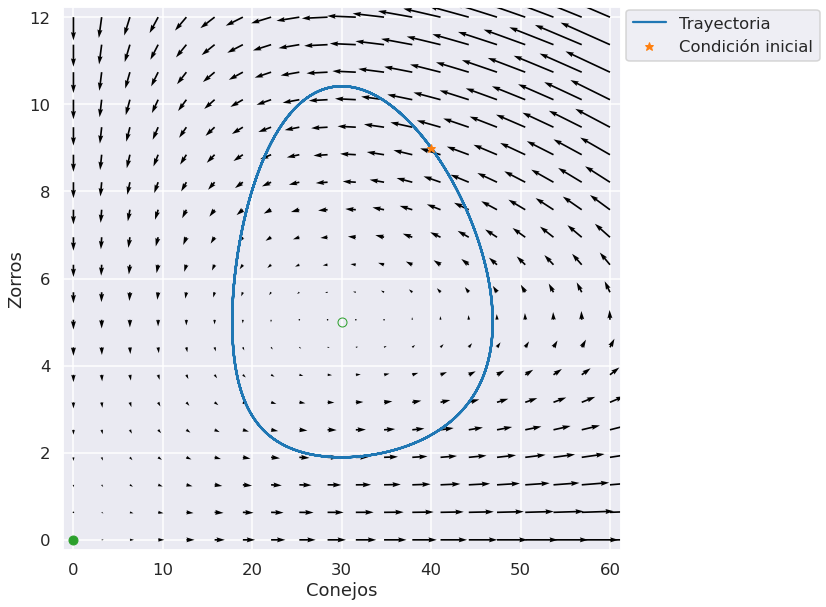

In [56]:
## Parámetros de integración
t0 = 0
tf = 200
h = 0.05
t_span = (t0, tf)
t_eval = np.arange(t0, tf, h)

## Resolvemos el sistema para distintas condiciones iniciales,
## para las cuales graficaremos las trayectorias
condiciones_iniciales = [
    (40, 9),
    #(20, 5)
]
soluciones = []
for i, y0 in enumerate(condiciones_iniciales):
    sol = solve_ivp(FoxesVsRabbits, t_span=t_span, y0=y0, t_eval=t_eval, max_step=h, args=args)
    soluciones.append(sol)

## Creamos una grilla en el espacio de fases,
## representada por las variables R y S
r_values = np.linspace(0,60,20)
s_values = np.linspace(0,12,20)
R, S = np.meshgrid(r_values, s_values)

## En cada punto de la grilla graficamos una flecha. Las variables
## U y V representan las coordenadas de las flechas 
U, V = FoxesVsRabbits(None, [R, S], *args)

## Realizamos el gráfico
fig, ax = plt.subplots(figsize=(10,10))
#ax.set_xlim(-0.05,3.05)
#ax.set_ylim(-0.05,2.05)
ax.set_ylabel('Zorros')
ax.set_xlabel('Conejos')

## Graficamos el campo de pendientes
ax.quiver(R, S, U, V)

## Punto fijo intestable
ax.plot(gamma/delta, alpha/beta, 'o', fillstyle='none', color=GREEN)

## Punto fijo estable
ax.plot(0, 0, 'o', color=GREEN)

## Graficamos trayectorias
for i, y0 in enumerate(condiciones_iniciales):
    sol = soluciones[i]
    ax.plot(sol.y[0], sol.y[1], color=BLUE, label='Trayectoria')

## Condiciones iniciales
for i, y0 in enumerate(condiciones_iniciales):
    ax.plot(*y0, '*', color=ORANGE, label='Condición inicial')
    
ax.margins(0.02)
ax.legend(loc=(1.01, 0.9))
plt.show()

In [4]:
## Parámetros de integración
h = 0.05
t0 = 0
tf = h*2**13
t_span = (t0, tf)
t_eval = np.arange(t0, tf, h)
n = t_eval.shape[0]
print('Tf = {}'.format(tf), np.log2(n))

## Definimos condicion inicial e integramos
y0 = (40, 9)
sol = solve_ivp(FoxesVsRabbits, t_span=t_span, y0=y0, t_eval=t_eval, args=args)

Tf = 409.6 13.0


0.01220703125 81.92 514.7185403641517


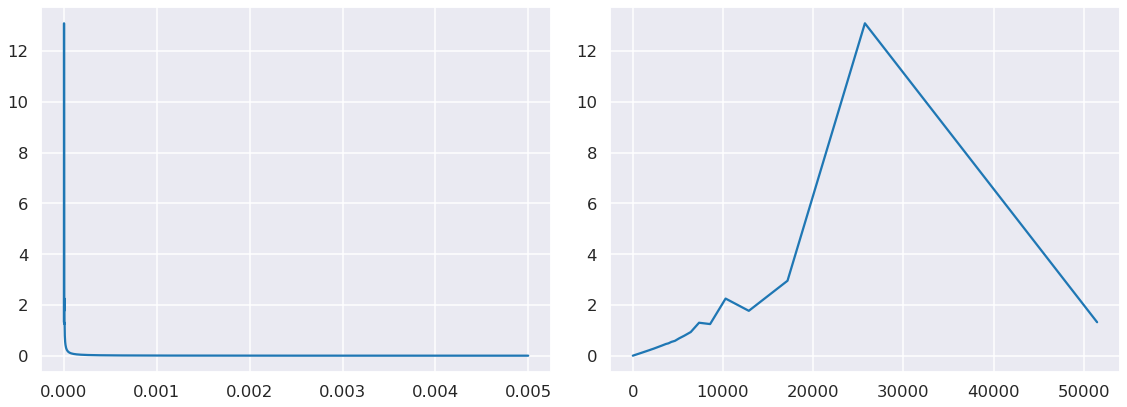

In [ ]:
freqs = fftfreq(n)
mask = freqs > 0
fft_vals = fft(sol.y[0])
fft_theo = 2*np.abs(fft_vals/n)

freq_max = freqs[np.argmax(fft_theo[mask])]
print(freq_max/h, h/freq_max, 2*np.pi*h/(freq_max))

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
#ax.set_xlim(0, 0.01)
ax.plot(freqs[mask]*h, fft_theo[mask])

ax = axes[1]
#ax.set_xlim(0, 10000)
ax.plot(2*np.pi/freqs[mask], fft_theo[mask])

plt.tight_layout()
plt.show()

In [ ]:
fft_theo

array([59.81618722,  0.17288029,  0.14374274, ...,  0.14124545,
        0.14374274,  0.17288029])

(0.0, 100.0)

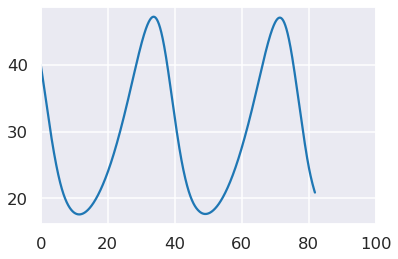

In [ ]:
plt.plot(sol.t, sol.y[0])
plt.xlim(0, 100)